### Prepare Data Set

In [48]:
import pandas as pd
import pickle
import numpy as np


# 0. load (and sort) data frame
seed = 42
main = pd.read_csv('data/df.csv').sample(frac=1, random_state= seed)

# 1. remove instances with imputed target variable
with open('data/timesteps_missing_data.pkl', 'rb') as pickle_file:
    timestep_missing_data = pickle.load(pickle_file)


# exclude values 
main_no_impute = main.copy()

for id in timestep_missing_data.keys():  
    for timestep in timestep_missing_data.get(id):
        #exclude row which match indexing (id and timestep of imputed value)
        main_no_impute = main_no_impute[~((main_no_impute['id'] == id) & (main_no_impute['time_step'] == timestep))]

print(f'Imputed Instances excluded: {main.shape[0] - main_no_impute.shape[0]}')

# 2. add column of weighted mean pollution
# Function to calculate weighted mean pollution based on similarity in distance to the city center
def weighted_mean_pollution(row):

    # Filter for other stations at the same timestamp
    same_time = main[main['time_step'] == row['time_step']]
    # Exclude the current station
    other_stations = same_time[same_time['id'] != row['id']]
    # similarity weights based on the inverse of the absolute difference in distances
    weights = 1 / (1 + np.abs(other_stations['distance_city'] - row['distance_city']))
    # Calculate the weighted mean pollution
    weighted_mean = np.average(other_stations['NO2'], weights=weights)
    return weighted_mean


# add weighted mean pollution for each time step
main_no_impute['weighted_mean_pollution'] = main_no_impute.apply(weighted_mean_pollution, axis=1)    

# 3. separate test from training station based on id 
# TEST STATIONS: mc117, mc018, mc145
main = main_no_impute.copy()
test_data_mc117 = main[main['id'] == 'mc117'].sort_values('time_step')
test_data_mc018 = main[main['id'] == 'mc018'].sort_values('time_step')
test_data_mc145 = main[main['id'] == 'mc145'].sort_values('time_step')

# 4. exclude test stations and recompute weighted mean based on training stations only
train_df = main[~main['id'].isin(['mc117', 'mc018', 'mc145'])]
train_df['weighted_mean_pollution'] = train_df.apply(weighted_mean_pollution, axis=1) 

Imputed Instances excluded: 722


C:\Users\Ri_sc\AppData\Local\Temp\ipykernel_10008\2143347720.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['weighted_mean_pollution'] = train_df.apply(weighted_mean_pollution, axis=1)


In [47]:
main = pd.read_csv('data/df_processed.csv').sample(frac=1, random_state= seed)
features = ['time_step', 'NO2','id','prec_mm', 'temp', 'wind_degree', 'wind_speed',
       'free_wind', 'prop_intercept_200', 'GVI_25', 'tvi_200', 'prop_main_', 'nearest_in', 
       'pop_500', 'lai_factor', 'distance_city', 'weekend', 'rushhour', 'prec_bool']

main = main[features]
main.to_csv('data/df.csv')

### Wrapper-based feature importance

retrain model n times for n feature, while masking (leaving out) the nth feature

In [49]:
# 6. prediction & model performance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


# 
test_data_frames = {'mc117': test_data_mc117,
                    'mc018': test_data_mc018,
                    'mc145': test_data_mc145,}

# define RF parameters
parameter = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5}

# define considered features (selection based on multicollinearity and mutual information (MI))
features = ['prec_mm', 'temp', 'wind_degree', 'wind_speed', 'free_wind', 'prop_intercept_200', 'GVI_25', 'tvi_200', 'prop_main_', 
       'nearest_in', 'pop_500', 'lai_factor', 'weighted_mean_pollution','weekend', 'rushhour', 'prec_bool']

permutation_importance_all = {}

for feature in features:
    
    # train model    
    current_features = features.copy() 
    current_features.remove(feature) # mask-out current feature

    X_train = train_df[current_features]
    y_train = train_df['NO2']

    model = RandomForestRegressor(**parameter, n_jobs=-1) # initiate model with defined parameter
    model.fit(X_train, y_train) 


    # predict and save score
    scores = []
    for test_station in ['mc018', 'mc145', 'mc117']:

        current_df = test_data_frames[test_station].copy().reset_index()
        X_test = current_df[current_features]
        y_test = current_df['NO2']
        
        y_pred = model.predict(X_test) # evaluate model
        scores.append(r2_score(y_test, y_pred))
        
    permutation_importance_all[feature] =  scores
    

### Visualized deviation in R2 performance for wrapper importance

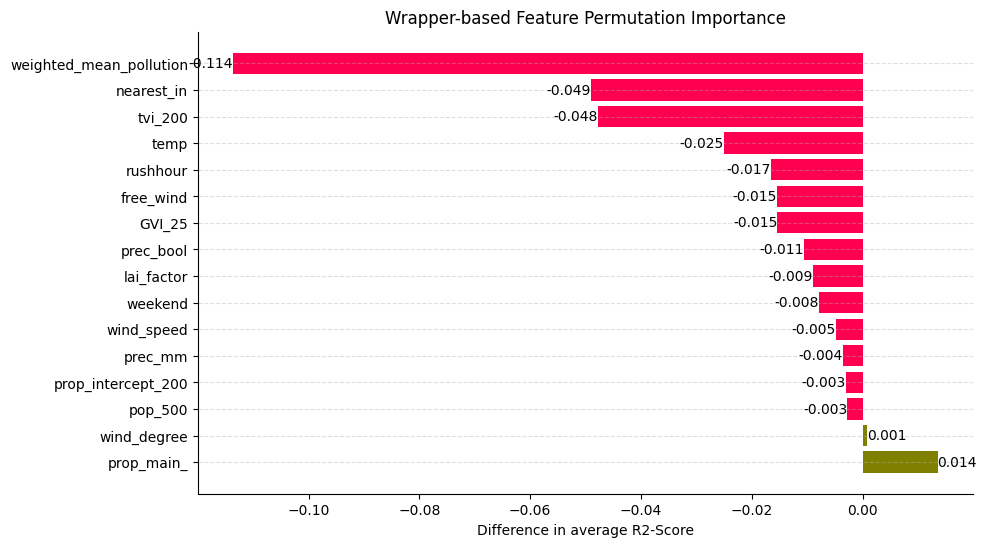

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

select = pd.DataFrame(permutation_importance_all).transpose()
select['mean_r2'] = (select[0] + select[1]  +select[2])/3
select['difference'] = select['mean_r2'] - 0.613
df = select.sort_values('difference', axis= 0).filter(['difference'])

# Load your data into a DataFrame (adjust the file path and method according to your data format)
# For example, if it's a CSV file:

# Sorting the DataFrame by the 'difference' column in ascending order
df = df.sort_values(by='difference', ascending=False)

# Creating the horizontal bar plot
plt.figure(figsize=(10, 6))
colors = ['olive' if x > 0 else '#ff0051' for x in df['difference']]
bars = plt.barh(df.index, df['difference'], color=colors)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center', ha='right' if bar.get_width() < 0 else 'left')

# Setting labels and title
plt.xlabel('Difference in average R2-Score')
plt.title('Wrapper-based Feature Permutation Importance')

# Customize the plot to remove borders and only display horizontal grid lines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.grid(axis='y', linestyle ='--', alpha = 0.4)

# Display the plot
plt.savefig('results/figures/wrapper_importance_RF.png', dpi = 500)
plt.show()
